In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, f1_score
from xgboost import XGBClassifier, plot_importance
import shap
import joblib
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.combine import SMOTEENN

In [2]:
df = pd.read_csv("Telco-Customer-Churn.csv")
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(inplace=True)
df.drop(columns=['customerID'], inplace=True)
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})


In [3]:
df['Family'] = df[['SeniorCitizen', 'Partner', 'Dependents']].astype(str).agg('_'.join, axis=1)
df.drop(columns=['SeniorCitizen', 'Partner', 'Dependents'], inplace=True)

def tenure_bucket(tenure):
    if tenure <= 12:
        return '0-1 Year'
    elif tenure <= 24:
        return '1-2 Years'
    elif tenure <= 48:
        return '2-4 Years'
    else:
        return '4+ Years'

df['TenureGroup'] = df['tenure'].apply(tenure_bucket)

In [4]:
X = df.drop(columns='Churn')
y = df['Churn']

categorical = X.select_dtypes(include='object').columns.tolist()
numerical = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical),
    ('num', StandardScaler(), numerical)
])

xgb = XGBClassifier(random_state=42)

pipeline = ImbPipeline([
    ('preprocessing', preprocessor),
    ('smoteenn', SMOTEENN(random_state=42)),
    ('classifier', xgb)
])

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [6]:
#  Hyperparameter Tuning
grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [3, 5],
    'classifier__learning_rate': [0.01, 0.1],
    'classifier__scale_pos_weight': [1, sum(y==0)/sum(y==1)]
}

gs = GridSearchCV(pipeline, param_grid=grid, cv=3, scoring='roc_auc', verbose=1)
gs.fit(X_train, y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['gender',
                                                                          'PhoneService',
                                                                          'MultipleLines',
                                                                          'InternetService',
                                                                          'OnlineSecurity',
                                                                          'OnlineBackup',
                                                                          'DeviceProtection',
                                                                          'TechSupport',
                                                                          'StreamingTV',
                                                                          'StreamingMovies',
                                                                          'Contract',
                                                                          'PaperlessBilling',
                                                                          'PaymentMethod',
                                                                          'Family',...
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None, ...))]),
             param_grid={'classifier__learning_rate': [0.01, 0.1],
                         'classifier__max_depth': [3, 5],
                         'classifier__n_estimators': [100, 200],
                         'classifier__scale_pos_weight': [1,
                                                          2.7624398073836276]},
             scoring='roc_auc', verbose=1)

In [7]:
#  Threshold Optimization based on F1-Score
y_prob = gs.predict_proba(X_test)[:, 1]
thresholds = np.arange(0.2, 0.61, 0.01)
f1_scores = [f1_score(y_test, y_prob >= t) for t in thresholds]

best_threshold = thresholds[np.argmax(f1_scores)]
print(f"\nBest Threshold based on F1-score: {best_threshold:.2f}")




Best Threshold based on F1-score: 0.53



Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.68      0.78      1033
           1       0.48      0.83      0.61       374

    accuracy                           0.72      1407
   macro avg       0.70      0.75      0.69      1407
weighted avg       0.80      0.72      0.73      1407


Confusion Matrix:
 [[701 332]
 [ 65 309]]

ROC AUC Score: 0.8321655424468476


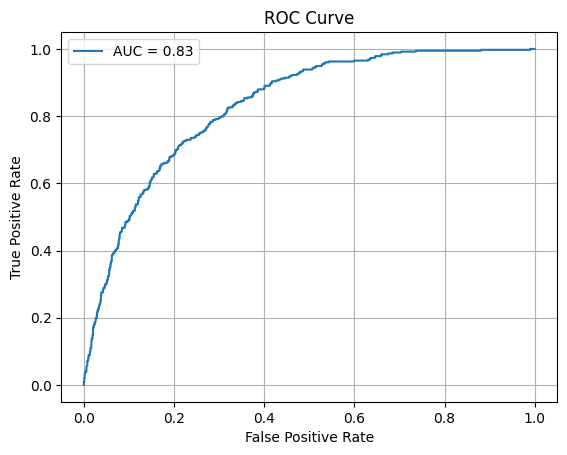

In [8]:
y_pred = (y_prob >= best_threshold).astype(int)

print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nROC AUC Score:", roc_auc_score(y_test, y_prob))

fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_prob):.2f}')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

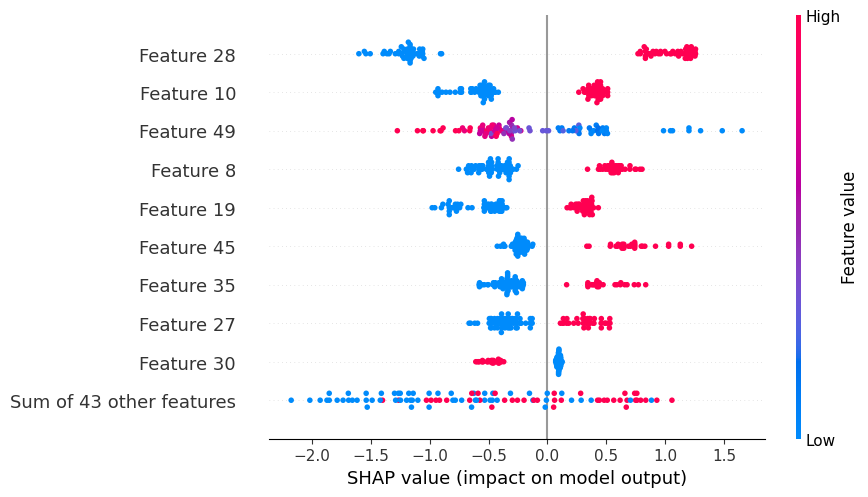

In [9]:
explainer = shap.Explainer(gs.best_estimator_.named_steps['classifier'])
X_encoded = preprocessor.fit_transform(X_test)
shap_values = explainer(X_encoded[:100])
shap.plots.beeswarm(shap_values)

In [10]:
joblib.dump(gs.best_estimator_, 'xgb_telco_pipeline.pkl')

['xgb_telco_pipeline.pkl']